In this file I attempt to find respecting record in ACMS (input) dataset for each report in output dataset

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

In [13]:
# acms_filename = './data/neo_takeoff_202404192324.csv'
acms_filename = './data/neo_takeoff_with_esn.csv'
acms_full = pd.read_csv(acms_filename, parse_dates=['reportts'], low_memory=False)

acnum = 'VQ-BDU'

acms = acms_full \
    .set_index('reportts') \
    .sort_index()

acms.shape

(152434, 208)

In [14]:
acms_full.shape

(152434, 209)

In [15]:
egtm_raw = pd.read_csv('./data/Data EGT N1Vib ACC ITT.csv', parse_dates=['RECORDED_DT']) \
    .rename(columns={
        'AIRCRAFT': 'acnum',
        'POSITION': 'pos',
        'RECORDED_DT': 'recorded_dt',
        'RWCTOMAR': 'egtm',
        'EGTM': 'egtm',
        'ESN': 'esn'
    }) \
    .loc[:, :'egtm']

egtm_raw['recorded_dt'] = pd.to_datetime(egtm_raw['recorded_dt'], format='%m/%d/%Y %I:%M:%S', errors='raise')

egtm = egtm_raw.query(f'acnum == @acnum and egtm > 0')

egtm.head()

,acnum,pos,esn,recorded_dt,egtm
0,VQ-BDU,1,770329,2019-01-04 10:17:56,37.446
1,VQ-BDU,1,770329,2019-01-04 14:35:54,36.467
2,VQ-BDU,1,770329,2019-01-05 11:29:42,35.738
3,VQ-BDU,1,770329,2019-01-05 14:56:20,36.519
4,VQ-BDU,1,770329,2019-01-05 19:50:58,36.441


In [16]:
egtm_raw.groupby('acnum').count().index.to_list()

['VP-BWB',
 'VP-BWM',
 'VP-BWN',
 'VQ-BCR',
 'VQ-BDQ',
 'VQ-BDU',
 'VQ-BGU',
 'VQ-BRA',
 'VQ-BRI']

In [17]:
egtm = egtm.set_index('recorded_dt').sort_index()
egtm

,acnum,pos,esn,egtm
recorded_dt,,,,
2018-07-11 09:44:38,VQ-BDU,2,770704,39.054
2018-07-11 14:11:47,VQ-BDU,2,770704,43.644
2018-07-11 18:50:00,VQ-BDU,2,770704,41.193
2018-07-12 01:45:02,VQ-BDU,2,770704,40.531
2018-07-12 09:42:44,VQ-BDU,2,770704,39.994
...,...,...,...,...
2020-02-08 05:19:23,VQ-BDU,2,770704,12.294
2020-02-08 23:34:32,VQ-BDU,2,770704,12.012
2020-02-08 23:34:32,VQ-BDU,1,770329,16.193


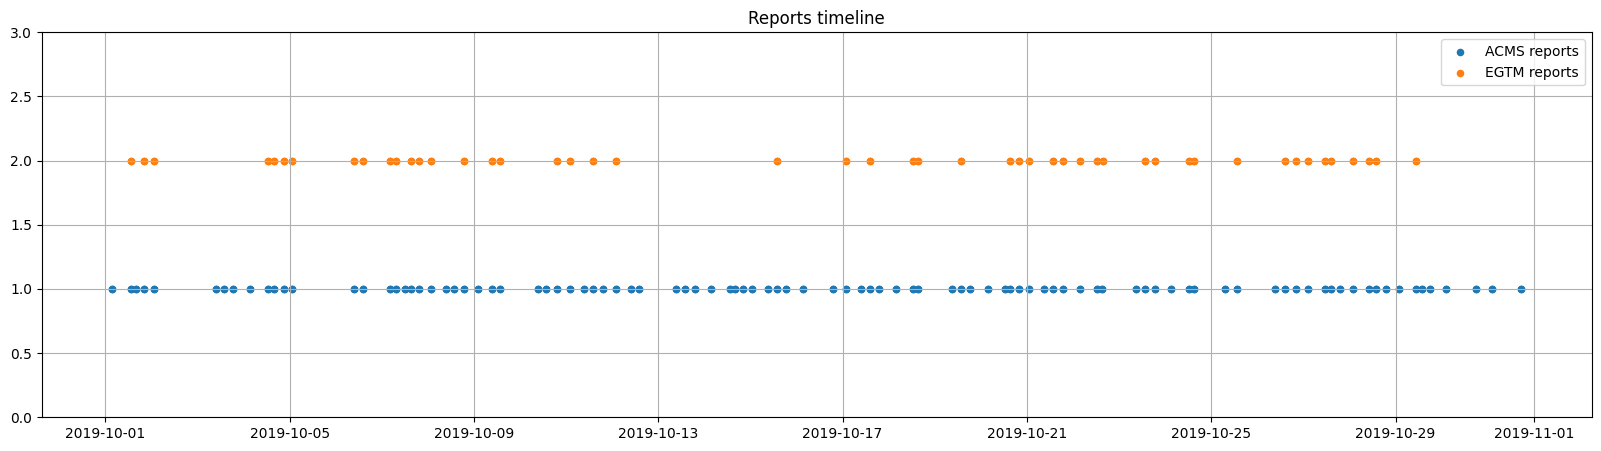

In [18]:
acms_filtered = acms[
    (pd.to_datetime(acms.index).year == 2019) &
    (pd.to_datetime(acms.index).month == 10)
    # (pd.to_datetime(acms.index).day <= 15)  
    # (pd.to_datetime(acms.index).day <= 21)
]

acms_line = acms_filtered.query('acnum == @acnum').index

egtm_filtered = egtm[
    (pd.to_datetime(egtm.index).year == 2019) &
    (pd.to_datetime(egtm.index).month == 10) 
    # (pd.to_datetime(egtm.index).day <= 15) 
    # (pd.to_datetime(egtm.index).day <= 21) 
]

egtm_line = egtm_filtered.index

fig, ax = plt.subplots(figsize=(20, 5))

ax.scatter(acms_line, y=acms_line.map(lambda _ : 1), s=20)
ax.scatter(egtm_line, y=egtm_line.map(lambda _: 2), s=20)
ax.legend(["ACMS reports", "EGTM reports"])
ax.set_ylim([0, 3])
ax.set_title("Reports timeline")
ax.grid(which='minor', alpha=1)
ax.grid(which='major', alpha=1)
plt.show()

Для 1672 записей разница во времени *delta_t = output_t - input_t* составляет не более +30 секунд. Эти записи являются наиболее чистыми данными, которые в дальнейшем я буду использовать для построения baseline-моделей. Есть также небольшая часть данных, для которых delta_t отрицательна. На данный момент эти записи я не включаю в датасет, так как нет уверенности в их корректности. 

Датасет `takeoff-merged-VQ-BGU-30s.csv` будет основным для борта VQ-BGU.

In [19]:
res = []

for acnum in egtm_raw.groupby('acnum').count().index.to_list():
  for pos in [1, 2]:
    egtm_to_merge = egtm_raw \
      .query('acnum == @acnum and pos == @pos') \
      .reset_index().rename(columns={'recorded_dt': 'reportts'}) \
      .set_index('reportts').sort_index() \
      .drop(columns=['acnum', 'pos', 'esn'])

    m = pd.merge_asof( 
      acms.query('acnum == @acnum and pos == @pos'),
      egtm_to_merge,
      on='reportts',
      direction='nearest',
      tolerance=pd.to_timedelta('15 sec')
    ).dropna(subset=['egtm'])

    if m.shape[0] < 10:
      continue

    res.append(m)

merged2 = pd.concat(res)
merged2.shape

(6866, 211)

In [20]:
print("Merge result:")
merged2.groupby(['acnum', 'pos']).count()[['reportts']]

Merge result:


reportts
acnum  pos          
VP-BWB 1         254
       2         254
VP-BWM 1         279
       2         279
VP-BWN 1         201
       2         201
VQ-BCR 1         524
       2         556
VQ-BDQ 1         395
VQ-BDU 1         716
       2        1225
VQ-BGU 1         786
       2         783
VQ-BRI 1          47
       2         366

In [23]:
# merged2.to_csv('./data/takeoff-merged-all-neo-ESN.csv', index=False)